# ML 101 Recap

**ML = model + loss + optimizer**


## Linear regression example

1. Model:
  - $f(X) = X \beta = \hat y$

2. Loss / criterion:
  - $ err_i = y_i - f(X_i)$
  - $MSE = \frac{1}{n} \sum_{i=1}^{N} err_i^2$
  
3. Optimize:
  - minimize the MSE yields the optimal $\hat\beta$ (after doing some math)
  - $\hat\beta = (X^TX)^{-1}X^Ty$
  - (or, more generally, use gradient descent to optimize the parameters)

In [1]:
import numpy as np
from numpy.linalg import inv
from numpy.linalg import multi_dot as mdot

import matplotlib.pyplot as plt

%matplotlib inline

## LinReg with numpy

In [2]:
X = np.random.random((5, 3))
y = np.random.random(5)
X.shape, y.shape

((5, 3), (5,))

Calculate the optimal parameter:
$\hat\beta = (X^T X)^{-1} X^T y$

In [3]:
XT = X.T  # transpose

beta_ = mdot([inv(XT @ X), XT, y])
beta_

array([ 1.1605935 , -0.0078017 , -0.21605467])

In [4]:
XT = X.T  # transpose

beta_ = inv(XT @ X) @ XT @ y
beta_

array([ 1.1605935 , -0.0078017 , -0.21605467])

The model $f$:

In [5]:
def f(X, beta):
    return X @ beta

f(X, beta_)

array([0.33491906, 0.54723564, 0.79542599, 0.56091385, 0.87199135])

## LinReg with PyTorch

In [6]:
import torch

In [7]:
# X = torch.rand((5, 3))
# y = torch.rand(5)
X = torch.from_numpy(X)
y = torch.from_numpy(y)
X.shape, y.shape

(torch.Size([5, 3]), torch.Size([5]))

$\hat\beta = (X^T X)^{-1} X^T y$

In [8]:
XT = X.t()

beta__ = (XT @ X).inverse() @ XT @ y
beta__

tensor([ 1.1606, -0.0078, -0.2161], dtype=torch.float64)

In [9]:
beta__.numpy() - beta_

array([-2.22044605e-16,  5.55111512e-17,  1.38777878e-16])

## LinReg with PyTorch and Gradent Descent

Previously, we had to do some math to calculate the optimal $\hat\beta$.
PyTorch calculates the gradients for us automatically (more on that later)
and we can use some version of gradient desctent to find our $\hat\beta$.

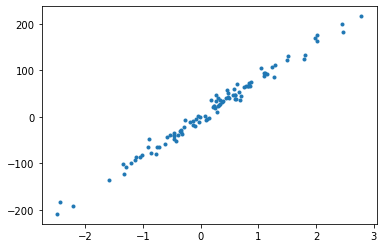

In [10]:
from sklearn.datasets import make_regression

n_features = 1
n_samples = 100

X, y = make_regression(
    n_samples=n_samples,
    n_features=n_features,
    noise=10,
)

fix, ax = plt.subplots()
ax.plot(X, y, ".")

In [11]:
X = torch.from_numpy(X).float()
y = torch.from_numpy(y.reshape((n_samples, n_features))).float()

In [12]:
from torch import nn

class LinReg(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.beta = nn.Linear(input_dim, 1)
        
    def forward(self, X):
        return self.beta(X)


model = LinReg(n_features)

In [13]:
criterion = nn.MSELoss()

In [14]:
from torch import optim

optimizer = optim.SGD(model.parameters(), lr=0.00001)

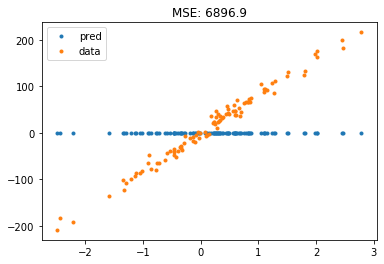

In [15]:
# Train step
model.train()
optimizer.zero_grad()

y_ = model(X)

loss = criterion(y_, y)
loss.backward()
optimizer.step()

# Eval
model.eval()
with torch.no_grad():
    y_ = model(X)
    

# Vis
fig, ax = plt.subplots()
ax.plot(X.numpy(), y_.numpy(), ".", label="pred")
ax.plot(X.numpy(), y.numpy(), ".", label="data")
ax.set_title(f"MSE: {loss.item():0.1f}")
ax.legend();

In [16]:
model.beta

Linear(in_features=1, out_features=1, bias=True)

In [17]:
model.beta.weight

Parameter containing:
tensor([[0.1697]], requires_grad=True)

In [18]:
model.beta.weight.data

tensor([[0.1697]])

In [19]:
model.beta.bias

Parameter containing:
tensor([-0.2811], requires_grad=True)

## LinReg with GPU

Simply move the data and the model to the GPU.

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = LinReg(n_features).to(device)  # <-- here
optimizer = optim.SGD(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

X, y = X.to(device), y.to(device)  # <-- here

The rest stays the same.

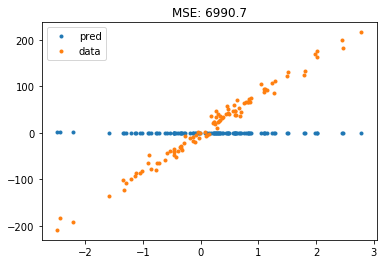

In [21]:
# Train step
model.train()
optimizer.zero_grad()

y_ = model(X)
loss = criterion(y_, y)

loss.backward()
optimizer.step()

# Eval
model.eval()
with torch.no_grad():
    y_ = model(X)    

# Vis
fig, ax = plt.subplots()
ax.plot(X.cpu().numpy(), y_.cpu().numpy(), ".", label="pred")
ax.plot(X.cpu().numpy(), y.cpu().numpy(), ".", label="data")
ax.set_title(f"MSE: {loss.item():0.1f}")
ax.legend();